In [5]:
import dataframe_image as dfi
import xgboost
import os
import shap

from fpdf import FPDF
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.inspection import PartialDependenceDisplay as PDP
from sklearn.inspection import partial_dependence as pdep
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


%load_ext autoreload
%autoreload 
import market_models.src.features.build_features as build_features

xgboost.set_config(verbosity=0)


In [6]:
def prepareDir(dir):
    if not os.path.isdir(dir):
        os.mkdir(dir)
    for file in os.listdir(dir):
        os.remove(dir + file)

In [7]:
####### PATHS

INPUT = '../data/processed/'
INTERMEDIATE = '../reports/'
OUTPUT = '..data/processed/'

DATA_NAME = 'netrisk_casco_2023_11_14__2023_11_20__2023_12_12'

DATA_PATH = f'{INPUT}{DATA_NAME}_processed.csv'
FEATURES_PATH = f'{INPUT}{DATA_NAME}_features.txt'
CATEGORIES_PATH = f'{INPUT}external/'


####### CONSTANTS

TEST_SIZE = 0.1
RANDOM_STATE = 42


def fair_obj(preds, dtrain):
    """y = c * abs(x) - c**2 * np.log(abs(x)/c + 1)"""
    x = preds - dtrain.get_labels()
    c = 1
    den = abs(x) + c
    grad = c * x / den
    hess = c * c / den ** 2
    return grad, hess


DEFAULT_PARAMS = {
    'objective': 'reg:squarederror',
    'booster': 'gbtree',
    'eval_metric': 'mae',
    'n_estimators': 100,
    'eta': 0.3,
    'max_depth': 6,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'num_boost_round': 100,
    'early_stopping_rounds': None,
    'seed': 42
}



BONUS_MALUS_CLASSES = ['B10', 'B9', 'B8', 'B7', 'B6', 'B5', 'B4', 'B3', 'B2', 'B1', 'A0', 'M1', 'M2', 'M3', 'M4']
KPI_TABLE_COLUMNS = ['MAE', 'RMSE', 'MAPE', 'Avg target']

TARGET_VARIABLE = 'ALFA_price'
PRED_TARGET_VARIABLE = f'predicted_{TARGET_VARIABLE}'
CATEGORIES_PATH = f'{CATEGORIES_PATH}{TARGET_VARIABLE}'

KPI_DATA_PATH = f'{INTERMEDIATE}{DATA_NAME}_{TARGET_VARIABLE}_pdf_data/'
PDF_PATH = KPI_DATA_PATH

prepareDir(KPI_DATA_PATH)

In [8]:
KPI_DATA_PATH

'../reports/netrisk_casco_2023_11_14__2023_11_20__2023_12_12_ALFA_price_pdf_data/'

In [9]:
DATA = pd.read_csv(DATA_PATH)

In [10]:
DATA.filter(like = '_price').mean(axis = 0).round()

ALFA_price        135656.0
ALLIANZ_price     162921.0
GENERALI_price    156979.0
GENERTEL_price         NaN
GROUPAMA_price    133359.0
K&AMP;H_price     197332.0
KÖBE_price         94134.0
MAGYAR_price      118845.0
SIGNAL_price      174493.0
UNION_price       130068.0
UNIQA_price       138678.0
WÁBERER_price     138030.0
dtype: float64

In [11]:
DATA = pd.read_csv(DATA_PATH)
with open(FEATURES_PATH) as file:
    FEATURES = file.readlines()
    FEATURES = [feature.replace('\n', '') for feature in FEATURES]
    feature_dtypes = {feature.split(',')[0]: feature.split(',')[1] for feature in FEATURES}
    FEATURES = [feature.split(',')[0] for feature in FEATURES]

for feature in FEATURES:
    print(feature, feature_dtypes[feature])
    DATA[feature] = DATA[feature].astype(feature_dtypes[feature])
    if DATA[feature].dtype == 'category' and feature == 'BonusMalus':
        ordinal_encoder = OrdinalEncoder(categories=[BONUS_MALUS_CLASSES])
        DATA[feature] = ordinal_encoder.fit_transform(DATA[[feature]])
    elif DATA[feature].dtype == 'category':
        label_encoder = LabelEncoder()
        DATA[feature] = label_encoder.fit_transform(DATA[feature])

isRecent bool
CarMake category
CarAge int64
ccm int64
kw int64
kg int64
car_value float64
CarMakerCategory float64
PostalCode int64
PostalCode2 int64
PostalCode3 int64
Category int64
Longitude float64
Latitude float64
Age int64
LicenseAge int64
BonusMalus category
BonusMalusCode int64


In [12]:
DATA.dtypes

Unnamed: 0            int64
id_case               int64
DateCrawled          object
isRecent               bool
CarMake               int64
CarAge                int64
ccm                   int64
kw                    int64
kg                    int64
car_value           float64
CarMakerCategory    float64
PostalCode            int64
PostalCode2           int64
PostalCode3           int64
Category              int64
Longitude           float64
Latitude            float64
Age                   int64
LicenseAge            int64
BonusMalus          float64
BonusMalusCode        int64
ALFA_price          float64
ALLIANZ_price       float64
GENERALI_price      float64
GENERTEL_price      float64
GROUPAMA_price      float64
K&AMP;H_price       float64
KÖBE_price          float64
MAGYAR_price        float64
SIGNAL_price        float64
UNION_price         float64
UNIQA_price         float64
WÁBERER_price       float64
dtype: object

In [13]:
# Make last column name a variable to generelize
DATA = DATA[FEATURES + [TARGET_VARIABLE]]
DATA = DATA.dropna()
TRAIN_DATA, TEST_DATA = train_test_split(DATA, test_size=0.2, random_state=42)


In [26]:
DATA.dtypes

isRecent               bool
CarMake               int64
CarAge                int64
ccm                   int64
kw                    int64
kg                    int64
car_value           float64
CarMakerCategory    float64
PostalCode            int64
PostalCode2           int64
PostalCode3           int64
Category              int64
Longitude           float64
Latitude            float64
Age                   int64
LicenseAge            int64
BonusMalus          float64
BonusMalusCode        int64
ALFA_price          float64
dtype: object

In [27]:
# Make data overview

describe = pd.concat([DATA.describe(),
                      pd.DataFrame(np.array([len(DATA[col].unique()) for col in DATA.columns]).reshape(1, -1),
                                   index=['unique'], columns=DATA.columns)])
describeStyle = describe.T.style.format(precision=2)
dfi.export(describeStyle, KPI_DATA_PATH + 'dataOverview.png', dpi=200)

In [28]:
# Various model related methods

def makeDMatrix(data_features: pd.DataFrame,
                data_target: pd.DataFrame) -> xgboost.DMatrix:
    return xgboost.DMatrix(data_features, data_target, enable_categorical=True)

def model_train(train_data: pd.DataFrame = None, 
                test_data: pd.DataFrame = None, 
                features : list = FEATURES,
                target_variable: str = TARGET_VARIABLE, 
                param: dict = None) -> xgboost.Booster:
    
    if train_data is None:
        train_data = TRAIN_DATA
    
    if test_data is None:
        test_data = TEST_DATA
        
    if param is None:
        param = DEFAULT_PARAMS.copy()
    
    dtrain = xgboost.DMatrix(train_data[features], train_data[target_variable], enable_categorical=True)
    dtest = xgboost.DMatrix(test_data[features], test_data[target_variable], enable_categorical=True)

    param['max_depth'] = int(param['max_depth'])
    param['eval_metric'] = 'mae'

    eval_list = [(dtrain, 'train'), (dtest, 'eval')]

    return xgboost.train(param, dtrain, num_boost_round=param['n_estimators'], evals=eval_list, verbose_eval=False)


def merge_predictions(model: xgboost.Booster,
                     test_data: pd.DataFrame = None,
                     features: list = FEATURES,
                     target_variable: str = TARGET_VARIABLE) -> pd.DataFrame:
    
    if test_data is None:
        test_data = TEST_DATA
        
    pred_target_variable = f'predicted_{target_variable}'
    output = test_data.copy()
    
    dtest = makeDMatrix(test_data[features], test_data[target_variable])
    output[pred_target_variable] = model.predict(dtest)
 
    output['error'] = output[target_variable] - output[pred_target_variable]
    output['percentageError'] = output['error'] / output[target_variable] * 100
    return output


def plotHistErrorPercenage(prediction_data : pd.DataFrame) -> None:
    plt.hist(prediction_data.percentageError, range=[-100, 100], bins=40,
             weights=np.ones(len(prediction_data.percentageError)) / len(prediction_data.percentageError))
    plt.xlabel('Error percentage')
    plt.ylabel('Percent of errors')
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.savefig(KPI_DATA_PATH + 'ErrorDistribution.jpg')
    plt.show()


def plotFeatureDistribution(data: pd.DataFrame = None, feature : str = FEATURES[0]) -> None:
    
    if data is None:
        data = DATA
    
    plt.figure(figsize=(10, 10))
    if feature in feature_dtypes.keys() and feature_dtypes[feature] == 'bool':
        data[feature].value_counts().plot(kind='bar', title=feature)
        plt.savefig(KPI_DATA_PATH + feature + 'Distribution.jpg', bbox_inches='tight')
    else:
        plt.hist(data[feature], bins=40, weights=np.ones(len(data[feature])) / len(data[feature]), alpha=0.5)
        plt.xlabel(feature)
        plt.ylabel('Percent of values')
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
        plt.savefig(KPI_DATA_PATH + feature + 'Distribution.jpg', bbox_inches='tight')
    plt.close()



In [29]:
for feature in FEATURES:
    plotFeatureDistribution(feature = feature)

In [30]:
from typing import Optional


def kFoldCrossValidation(k: int = 5, 
                         data: pd.DataFrame = None,
                         features: list = FEATURES,
                         target_variable: str = TARGET_VARIABLE, 
                         param: Optional[dict] = DEFAULT_PARAMS, 
                         debug: bool = True) -> tuple:
    
    if data is None:
        data = DATA

    maes = []
    mses = []
    mapes = []
    
    kf = KFold(n_splits=k)
    fold_num = 0
    for train_ix, test_ix in kf.split(data):
        
        fold_num += 1
        
        train_data, test_data = data.iloc[train_ix], data.iloc[test_ix]
        model = model_train(train_data, test_data, features, target_variable, param)
        
        dtest = makeDMatrix(test_data[features], test_data[target_variable])
        test_preds = model.predict(dtest)
        
        mae = mean_absolute_error(test_data[target_variable].values, test_preds)
        mse = mean_squared_error(test_data[target_variable].values, test_preds)
        mape = mean_absolute_percentage_error(test_data[target_variable].values, test_preds)
        
        if debug:
            print(f"Summary for fold {fold_num}")
            print("Mean absolute error is {}, which is {}% of mean {}.".format(round(mae, 3), round(
                mae / data[target_variable].mean() * 100, 3), target_variable))
            print("Mean square error is {}.".format(round(mse, 3)))
            print("Mean absolute percentage error is {}%.".format(round(mape * 100, 3)))
            print("-------------------------------------------------------------")
        
        maes.append(mae)
        mses.append(mse)
        mapes.append(mape)

    mMae, sMae = np.mean(maes), np.std(maes)
    mRMse, sRMse = np.mean(np.sqrt(mses)), np.std(np.sqrt(mses))
    mMape, sMape = np.mean(mapes), np.std(mapes)
    meanPrice = data[target_variable].mean()

    rmMae, rsMae = round(mMae, 2), round(sMae / mMae * 100, 3)
    rmRMse, rsRMse = round(mRMse, 2), round(sRMse / mRMse * 100, 2)
    rmMape, rsMape = round(mMape * 100, 2), round(sMape / mMape, 3)

    if debug:
        print(
            f"Mean MAE over {k} fold Cross-validation is {rmMae} ± {rsMae}%, which is {round(mMae / meanPrice * 100, 3)} ± {round(sMae / meanPrice * 100, 3)}% percent of mean {target_variable}.")
        print(f"Mean RMSE over {k} fold Cross-validation is {rmRMse} ± {rsRMse}%.")
        print(f"Mean MAPE over {k} fold Cross-validation is {rmMape} ± {rsMape}%.")

    return rmMae, rmRMse, rmMape

In [31]:
hyperparameter_ranges = {
    'learning_rate': np.arange(0.01, 0.31, 0.01),
    'n_estimators': np.arange(100, 1100, 100),
    'max_depth': np.arange(3, 11),
    'min_child_weight': np.arange(1, 11),
    'subsample': np.arange(0.5, 1.01, 0.1),
    'colsample_bytree': np.arange(0.5, 1.01, 0.1),
    'gamma': np.arange(0, 0.21, 0.01),
    'lambda': np.arange(0, 1.1, 0.1),
}


def hyperparameter_tuning(data: pd.DataFrame = None,
                          features: list = FEATURES,
                          target_variable: str = TARGET_VARIABLE,
                          params: dict = None, 
                          plot_search=False) -> tuple:
    
    if data is None:
        data = DATA
    
    if params is None:
        params = DEFAULT_PARAMS.copy()
    
    best_hyperparameters = {}  # To store the best hyperparameter value for each parameter
    min_mae_values = {}  # To store the corresponding minimum MAE values

    for hp, hp_values in hyperparameter_ranges.items():
        maes = []
        print(f"Iterating over {hp} values...")

        # Initialize the minimum MAE and corresponding hyperparameter value
        min_mae = float('inf')
        best_value = None
        current_params = params
        for value in hp_values:
            current_params[hp] = value
            mae, mse, mape = kFoldCrossValidation(3, data, features, target_variable, params, debug = False)
            maes.append(mae)

            # Check if the current value gives a lower MAE
            if mae < min_mae:
                min_mae = mae
                best_value = value

        # Store the best hyperparameter value in the dictionary
        best_hyperparameters[hp] = best_value
        min_mae_values[hp] = min_mae

        if plot_search:
            # Plot the results
            plt.title(f'Search for optimal {hp} value:')
            plt.plot(hp_values, maes)
            plt.xlabel(f'{hp}')
            plt.ylabel('Mean Absolute Error (MAE)')
            plt.show()

    # Display the best hyperparameter values
    print("\nBest Hyperparameter Values:")
    for hp, value in best_hyperparameters.items():
        print(f"{hp}: {value}")

    mae, mse, mape = kFoldCrossValidation(3, data, features, target_variable, best_hyperparameters, debug = False)

    return best_hyperparameters, mae

In [32]:
space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'n_estimators': hp.choice('n_estimators', np.arange(100, 1300, 100, dtype=int)),
    'max_depth': hp.choice('max_depth', np.arange(2, 11, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 11, dtype=int)),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'gamma': hp.uniform('gamma', 0, 0.2),
    'lambda': hp.uniform('lambda', 0, 1),
    'reg_alpha': hp.uniform('reg_alpha', 40, 180),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'seed': 0,
}


def objective(space):
    params = space.copy()
    mae, rmse, mape = kFoldCrossValidation(k = 3, param = params, debug = False)
    print(f"Score: {mae}")
    return {"loss": mae, 'status': STATUS_OK}


trials = Trials()
best_hyperparams = fmin(fn=objective,
                            space=space,
                            algo=tpe.suggest,
                            max_evals=100,
                            trials=trials,
                            return_argmin=False)


Score: 10828.98                                        
Score: 10857.59                                                          
Score: 9942.86                                                           
Score: 10472.09                                                        
Score: 9086.07                                                        
Score: 20281.43                                                       
Score: 11436.15                                                       
Score: 13968.3                                                        
Score: 10801.96                                                       
Score: 9663.6                                                         
Score: 11896.24                                                        
Score: 10769.19                                                        
Score: 14670.85                                                        
Score: 11321.77                                                        
Score: 117

In [33]:
best_hyperparams

{'colsample_bytree': 0.6223082119207594,
 'gamma': 0.15174578439948572,
 'lambda': 0.9165619530581657,
 'learning_rate': 0.15210669421023149,
 'max_depth': 3,
 'min_child_weight': 2,
 'n_estimators': 1200,
 'reg_alpha': 127.47330030762639,
 'reg_lambda': 0.8754691417378591,
 'seed': 0,
 'subsample': 0.8110776806847463}

In [18]:
mae, rmse, mape = kFoldCrossValidation(k=3, param=best_hyperparams, debug=True)

Summary for fold 1
Mean absolute error is 12403.876, which is 9.216% of mean ALFA_price.
Mean square error is 728507369.576.
Mean absolute percentage error is 6.558%.
-------------------------------------------------------------
Summary for fold 2
Mean absolute error is 8838.98, which is 6.567% of mean ALFA_price.
Mean square error is 223875823.306.
Mean absolute percentage error is 6.618%.
-------------------------------------------------------------
Summary for fold 3
Mean absolute error is 8344.446, which is 6.2% of mean ALFA_price.
Mean square error is 264109582.178.
Mean absolute percentage error is 6.163%.
-------------------------------------------------------------
Mean MAE over 3 fold Cross-validation is 9862.43 ± 18.336%, which is 7.327 ± 1.344% percent of mean ALFA_price.
Mean RMSE over 3 fold Cross-validation is 19401.6 ± 27.79%.
Mean MAPE over 3 fold Cross-validation is 6.45 ± 0.031%.


In [34]:
mae, rmse, mape = kFoldCrossValidation(k=3, param=best_hyperparams, debug=True)

Summary for fold 1
Mean absolute error is 11391.555, which is 8.47% of mean ALFA_price.
Mean square error is 605344666.358.
Mean absolute percentage error is 5.958%.
-------------------------------------------------------------
Summary for fold 2
Mean absolute error is 7555.537, which is 5.618% of mean ALFA_price.
Mean square error is 177659223.144.
Mean absolute percentage error is 5.602%.
-------------------------------------------------------------
Summary for fold 3
Mean absolute error is 7076.631, which is 5.262% of mean ALFA_price.
Mean square error is 228086123.02.
Mean absolute percentage error is 5.371%.
-------------------------------------------------------------
Mean MAE over 3 fold Cross-validation is 8674.57 ± 22.262%, which is 6.45 ± 1.436% percent of mean ALFA_price.
Mean RMSE over 3 fold Cross-validation is 17678.39 ± 28.0%.
Mean MAPE over 3 fold Cross-validation is 5.64 ± 0.043%.


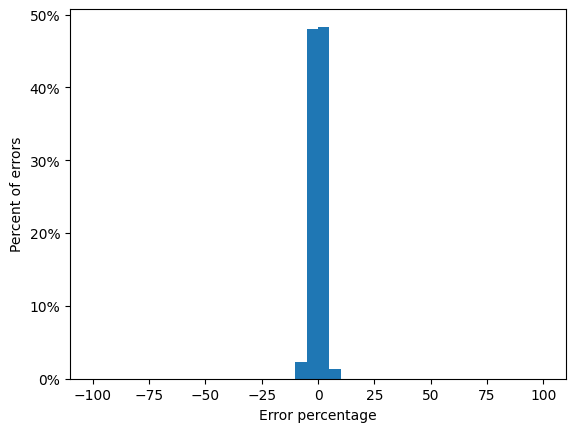

0.10    0.260752
0.20    0.506064
0.30    0.701930
0.40    1.034114
0.50    1.367005
0.60    1.822429
0.70    2.298302
0.80    2.833661
0.90    3.578400
0.99    6.762093
Name: percentageError, dtype: float64

In [17]:
model = xgboost.Booster(model_file = '../models/netrisk_casco_2023_11_14__2023_11_20_ALFA_price_model.json')
out = merge_predictions(model)
plotHistErrorPercenage(out)
out.percentageError.abs().quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99])

In [19]:
DATA.dtypes

isRecent               bool
CarMake               int64
CarAge                int64
ccm                   int64
kw                    int64
kg                    int64
car_value           float64
CarMakerCategory    float64
PostalCode            int64
PostalCode2           int64
PostalCode3           int64
Category              int64
Longitude           float64
Latitude            float64
Age                   int64
LicenseAge            int64
BonusMalus          float64
BonusMalusCode        int64
ALFA_price          float64
dtype: object

In [32]:
fulldmat = makeDMatrix(DATA[FEATURES], DATA[TARGET_VARIABLE])
out = DATA.copy()
out['error'] = out[TARGET_VARIABLE] - model.predict(fulldmat)
out = out[FEATURES + ['error']]
out[out['error'] < 1000] = 0
out[out['error'] > 1000] = 1
out['error'] = out['error'].astype(bool)

In [33]:
FEATURES

['isRecent',
 'CarMake',
 'CarAge',
 'ccm',
 'kw',
 'kg',
 'car_value',
 'CarMakerCategory',
 'PostalCode',
 'PostalCode2',
 'PostalCode3',
 'Category',
 'Longitude',
 'Latitude',
 'Age',
 'LicenseAge',
 'BonusMalus',
 'BonusMalusCode']

In [36]:


train_out, test_out = train_test_split(out, test_size = 0.1, random_state = 42)
train_out['isRecent'] = train_out['isRecent'].astype(bool)
test_out['isRecent'] = test_out['isRecent'].astype(bool) 
dtrain = xgboost.DMatrix(train_out[FEATURES], label = train_out['error'], enable_categorical=True)
dtest = xgboost.DMatrix(test_out[FEATURES], label= test_out['error'], enable_categorical=True)


params = {
    'objective': 'multi:softmax',  # Multiclass classification
    'num_class': 2,  # Number of classes
    'max_depth': 3,
    'learning_rate': 0.1,
    'eval_metric': 'merror'
}


num_rounds = 100
error_model = xgboost.train(params, dtrain, num_rounds)


In [41]:
error_model.predict(dtest)

array([1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0.,
       1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1.,
       0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
       1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [38]:
def get_errors(data = None, target_variable = TARGET_VARIABLE, quantile_ranges = [0, 0.01, 0.03, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.97, 0.99, 1]):
    if data is None:
        data = DATA
    errors = data.error
    absolute_erros = errors.abs()
    relative_errors = errors / data[TARGET_VARIABLE]
    errors_q = errors.quantile(quantile_ranges)
    abs_error_q = absolute_erros.quantile(quantile_ranges)
    relative_errors_q = relative_errors.quantile(quantile_ranges) * 100
    abs_relative_erros_q = np.abs(relative_errors).quantile(quantile_ranges) * 100
    quantile_df = pd.DataFrame(index = errors_q.index)
    quantile_df['error_q'] = errors_q
    quantile_df['abs_error_q'] = abs_error_q
    quantile_df['relative_error_q'] = relative_errors_q
    quantile_df['abs_relative_error_q'] = abs_relative_erros_q
    return quantile_df


In [39]:
get_errors(out)

,error_q,abs_error_q,relative_error_q,abs_relative_error_q
0.00,-86292.437500,8.843750,-47.836854,0.016629
0.01,-35695.156250,62.151250,-23.526993,0.055465
0.03,-24856.285625,96.412188,-19.430941,0.101040
0.05,-21227.368750,153.276563,-16.698261,0.150117
0.10,-13525.306250,386.551563,-11.660821,0.381001
0.20,-6970.278125,985.926563,-6.367359,1.087348
0.30,-4387.170313,2018.300000,-3.718025,1.971559
0.40,-1984.875000,3252.657813,-1.960909,2.864937
0.50,-459.898438,4437.945312,-0.427759,3.718707
0.60,267.493750,5668.140625,0.246193,5.022206


In [21]:
kFoldCrossValidation(k = 3)

Summary for fold 1
Mean absolute error is 16978.246, which is 12.614% of mean ALFA_price.
Mean square error is 1470956842.035.
Mean absolute percentage error is 8.459%.
-------------------------------------------------------------
Summary for fold 2
Mean absolute error is 10439.082, which is 7.756% of mean ALFA_price.
Mean square error is 436758907.536.
Mean absolute percentage error is 7.321%.
-------------------------------------------------------------
Summary for fold 3
Mean absolute error is 11061.21, which is 8.218% of mean ALFA_price.
Mean square error is 593721711.467.
Mean absolute percentage error is 7.315%.
-------------------------------------------------------------
Mean MAE over 3 fold Cross-validation is 12826.18 ± 22.976%, which is 9.529 ± 2.189% percent of mean ALFA_price.
Mean RMSE over 3 fold Cross-validation is 27872.75 ± 27.07%.
Mean MAPE over 3 fold Cross-validation is 7.7 ± 0.07%.


(12826.18, 27872.75, 7.7)

In [27]:
out['percentageError'].qanti

0.8193384223918575

In [22]:
kpi_data = [[mae, rmse, mape, round(DATA[TARGET_VARIABLE].mean(), 1)]]
kpi = pd.DataFrame(data=kpi_data, columns=KPI_TABLE_COLUMNS).astype('str')

In [23]:
kpi

,MAE,RMSE,MAPE,Avg target
0,10206.64,20770.91,6.49,134597.4


In [43]:
from sklearn.base import BaseEstimator, RegressorMixin
import statsmodels.formula.api as smf 


class XGBRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, booster, params=None):
        self.booster = booster
        self.params = params

    def fit(self, X, y):
        if self.params:
            dmatrix = xgboost.DMatrix(X, label=y)
            self.booster = xgboost.train(self.params, dmatrix)
        else:
            raise ValueError("XGBoost parameters not provided.")

        return self

    def predict(self, X):
        dmatrix = xgboost.DMatrix(X)
        return self.booster.predict(dmatrix)

In [44]:
sklrean_model = XGBRegressorWrapper(model, best_hyperparams)

In [ ]:
smf

In [ ]:
for col in DATA.columns:
    plotFeatureDistribution(feature = col)

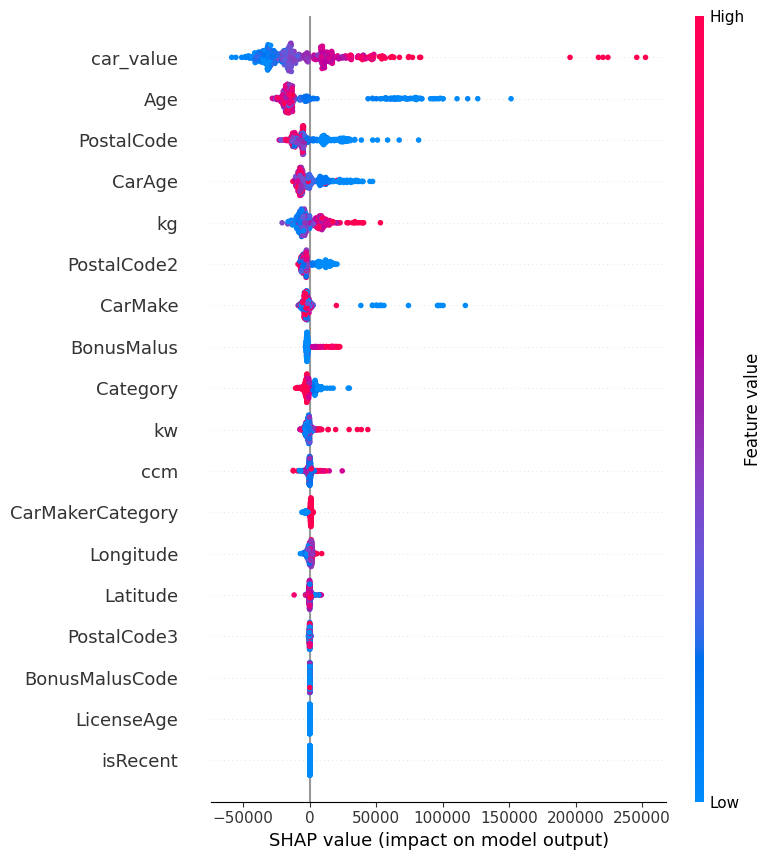

In [40]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(TEST_DATA[FEATURES].values)

shap.summary_plot(shap_values, TEST_DATA[FEATURES], feature_names=FEATURES)

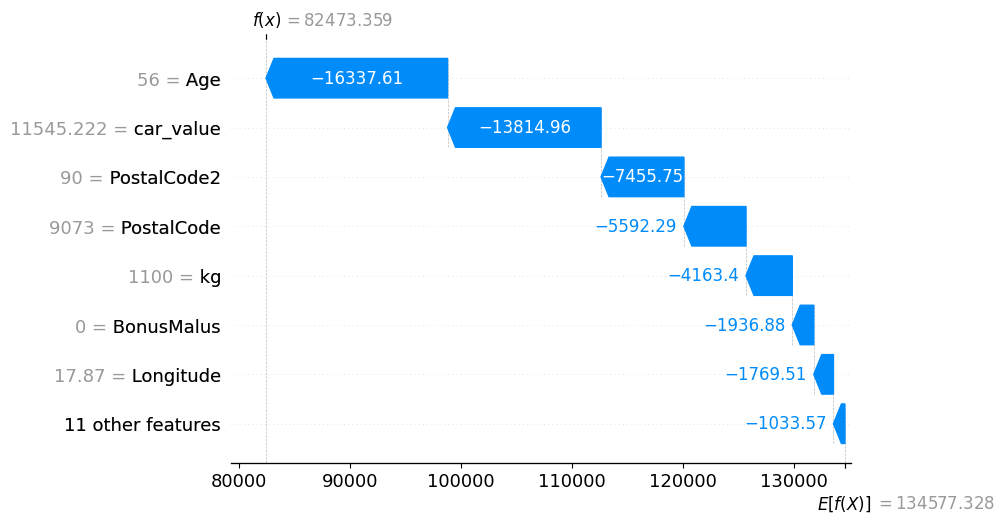

In [41]:
id = 21
plt.figure(figsize=(20, 20))
shap.waterfall_plot(shap.Explanation(values=shap_values[id],
                                     base_values=explainer.expected_value,
                                     data=TEST_DATA.iloc[id],
                                     feature_names=FEATURES),
                    max_display=8)  # Adjust max_display as needed

plt.show()

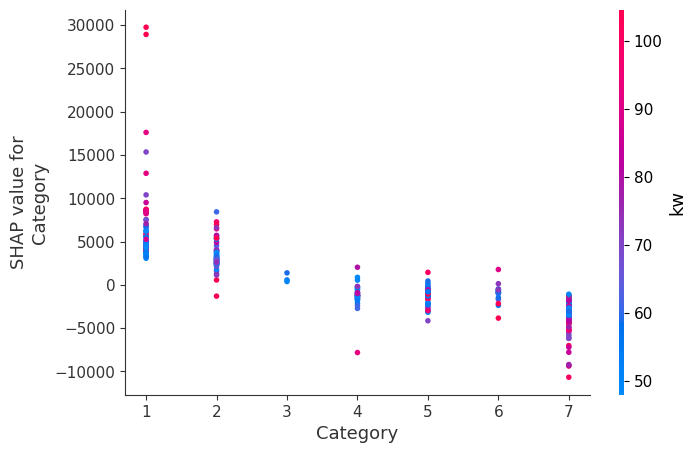

In [42]:
shap.dependence_plot('Category', shap_values, TEST_DATA[FEATURES])

In [66]:
def partial_dependence_analysis(model: xgboost.Booster,
                                data: pd.DataFrame = None,
                                feature_names: list = FEATURES,
                                grid_resolution : int = 100) -> tuple:
    
    if data is None:
        data = TRAIN_DATA
    
    importance_dict = {}
    pdp_dict = {}

    for feature_name in feature_names:
        if data[feature_name].dtype == 'category':  # Check if the variable is categorical
            unique_values = data[feature_name].unique()
            partial_dependence_values = []

            for value in unique_values:
                data_copy = data.copy()
                data_copy[feature_name] = value
                dmatrix = xgboost.DMatrix(data_copy.drop(TARGET_VARIABLE, axis=1))
                predictions = model.predict(dmatrix)
                partial_dependence_values.append(np.mean(predictions))

            importance_dict[feature_name] = np.std(partial_dependence_values)
            pdp_dict[feature_name] = (unique_values, partial_dependence_values)
        else:
            feature_range = np.linspace(data[feature_name].min(), data[feature_name].max(), grid_resolution)
            partial_dependence_values = []

            for value in feature_range:
                data_copy = data.copy()
                data_copy[feature_name] = value
                dmatrix = xgboost.DMatrix(data_copy.drop(TARGET_VARIABLE, axis=1))
                predictions = model.predict(dmatrix)
                partial_dependence_values.append(np.mean(predictions))

            importance_dict[feature_name] = np.std(partial_dependence_values)
            pdp_dict[feature_name] = (feature_range, partial_dependence_values)

    return pdp_dict, importance_dict

def plot_importance(features, importances, title="Feature importance", xlabel="Partial Dependence Feature Importance", ylabel="Features", show_values=True, values_format="{:.2f}", save_path = None, **kwargs):
 
    sorted_indices = np.argsort(importances)
    features = [features[i] for i in sorted_indices]
    importances = [importances[i] for i in sorted_indices]

    # Plotting
    fig, ax = plt.subplots()
    ax.barh(features, importances, **kwargs)

    # Customize plot
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if show_values:
        for i, v in enumerate(importances):
            ax.text(v, i, values_forsave_path = Nonemat.format(v), va='center')

    if save_path is not None:
        plt.savefig(save_path)
    return ax


In [67]:
pdp_dict, importances = partial_dependence_analysis(model)

In [68]:
importances

{'isRecent': 0.0,
 'CarMake': 16204.2705,
 'CarAge': 13064.9795,
 'ccm': 1023.5835,
 'kw': 11343.312,
 'kg': 8825.257,
 'car_value': 70615.42,
 'CarMakerCategory': 344.7196,
 'PostalCode': 7233.832,
 'PostalCode2': 4788.209,
 'PostalCode3': 173.5333,
 'Category': 3142.2625,
 'Longitude': 2448.119,
 'Latitude': 1162.3584,
 'Age': 33578.703,
 'LicenseAge': 0.0,
 'BonusMalus': 8783.983,
 'BonusMalusCode': 0.0}

<Axes: title={'center': 'Feature importance'}, xlabel='Partial Dependence Feature Importance', ylabel='Features'>

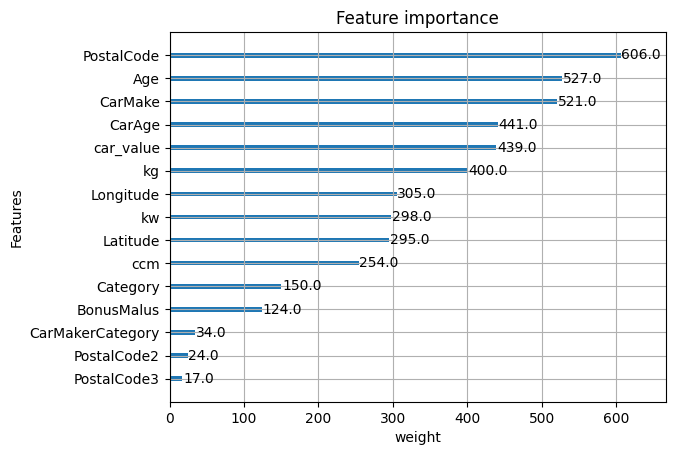

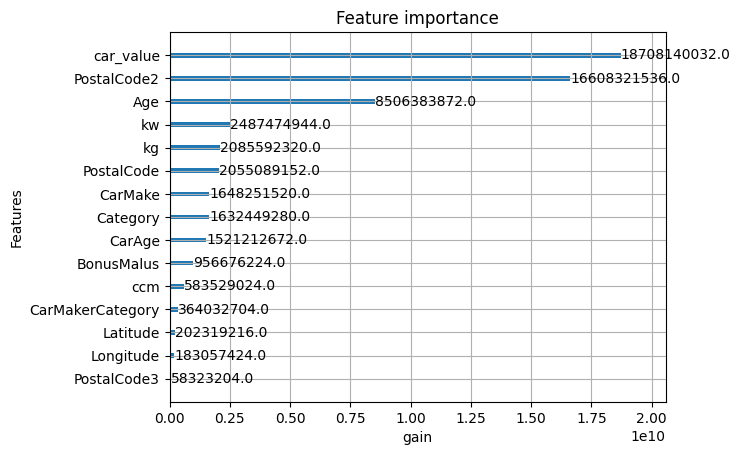

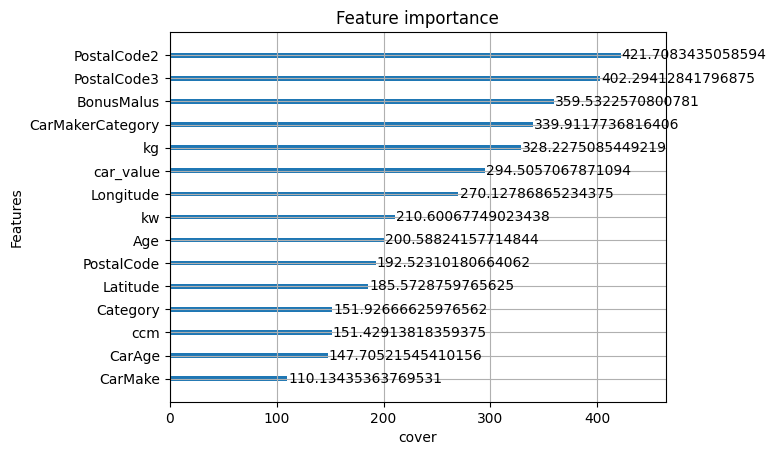

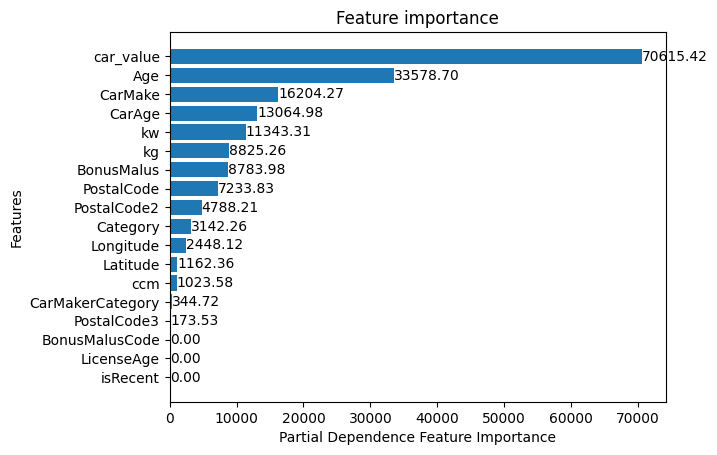

In [69]:
xgboost.plot_importance(model, importance_type = 'weight', xlabel = 'weight')
plt.savefig(f'{KPI_DATA_PATH}feature_importnace_weight.jpg')
xgboost.plot_importance(model, importance_type = 'gain', xlabel = 'gain')
plt.savefig(f'{KPI_DATA_PATH}feature_importnace_gain.jpg')
xgboost.plot_importance(model, importance_type = 'cover', xlabel = 'cover')
plt.savefig(f'{KPI_DATA_PATH}feature_importnace_cover.jpg')
plot_importance(list(importances.keys()), list(importances.values()), save_path = f'{KPI_DATA_PATH}feature_importnace_pdp.jpg')

In [49]:
for feature in FEATURES:
    feature_range, pdp_values = pdp_dict[feature]
    plt.plot(feature_range,pdp_values, label=feature)
    plt.xlabel('Feature Values')
    plt.ylabel('Partial Dependence')
    plt.title('Partial Dependence Plots for Selected Features')
    plt.legend()
    plt.savefig(f'{KPI_DATA_PATH}PDPplot{feature}.jpg')
    plt.close()

In [27]:
def getQauntSplit(step=50):
    return [i / 1000 for i in range(0, 1001, step)]


quant = getQauntSplit(int(np.ceil(100000 / len(TRAIN_DATA))))
qr = TEST_DATA[TARGET_VARIABLE].quantile(quant)
qp = pd.Series(model.predict(makeDMatrix(TEST_DATA[FEATURES], TEST_DATA[TARGET_VARIABLE]))).quantile(quant)

plt.scatter(qr, qp, alpha=0.8, s=40)
x = np.linspace(qr.min(), qr.max())
plt.plot(x, x, c='r')
plt.xlabel('Real quantiles for training data')
plt.ylabel('Predicted quantiles for training data')
plt.savefig(KPI_DATA_PATH + 'QQplot.jpg', bbox_inches='tight')
plt.close()

In [29]:
def quantPlot(out, feature, numQuant=20):
    type = True  # Does the feature have more than 20 unique values in train data, 20 because it looks bad with more
    fQuant = None
    cats = None
    if len(out[feature].unique()) > 30 and feature in feature_dtypes.keys() and feature_dtypes[feature] == 'object':
        return
    if len(out[feature].unique()) < numQuant or (
            feature in feature_dtypes.keys() and feature_dtypes[feature] == 'object'):
        out['QuantCat'] = out[feature]
        type = False
    else:
        fQuant = out[feature].quantile(getQauntSplit(1000 // numQuant)).values
        cats = list(pd.Series(fQuant).unique())

        def getQId(x):
            for i in range(0, len(cats) - 1):
                if x >= cats[i] and x <= cats[i + 1]:
                    return i
            return len(cats) - 1

        out['QuantCat'] = out[feature].apply(lambda x: getQId(x))
        cats = [str(round(cats[i], 2)) + "-" + str(round(cats[i + 1], 2)) for i in range(0, len(cats) - 1)]

    agg_age = out.groupby('QuantCat')

    fig, ax = plt.subplots(figsize=(14, 14))
    if type:
        ax.plot(sorted(list(out['QuantCat'].unique())), agg_age[TARGET_VARIABLE].mean().dropna(), marker='o', color='b',
                alpha=0.6)
        ax.plot(sorted(list(out['QuantCat'].unique())), agg_age[PRED_TARGET_VARIABLE].mean().dropna(), marker='o',
                color='r', alpha=0.6)
        ax.set_xticks(sorted(list(out['QuantCat'].unique())))
    else:
        ax.plot(sorted(list(out['QuantCat'].unique())), agg_age[TARGET_VARIABLE].mean().dropna(), marker='o', color='b',
                alpha=0.6)
        ax.plot(sorted(list(out['QuantCat'].unique())), agg_age[PRED_TARGET_VARIABLE].mean().dropna(), marker='o',
                color='r', alpha=0.6)
        if feature == 'CarMaker':
            ax.set_xticklabels(sorted([str(x)[:4] for x in list(out['QuantCat'].unique())]))
        else:
            ax.set_xticklabels(sorted(list(out['QuantCat'].unique())))

    plt.title('Mean Real vs Predicted price aggregated by {}'.format(feature))
    ax.legend(['Real', 'Predicted'])
    plt.savefig(KPI_DATA_PATH + 'quantPlot' + col + '.jpg', bbox_inches='tight')
    plt.close()
    ret = pd.DataFrame(agg_age[TARGET_VARIABLE].mean() - agg_age[PRED_TARGET_VARIABLE].mean())
    #print(ret)
    if type:
        #print(cats, out['QuantCat'].unique())
        ret.index = [cats[i] for i in range(len(cats)) if i in out['QuantCat'].unique()]

    return ret


out = merge_predictions(model)
agg_errors = {}
for col in TEST_DATA.columns:
    agg_errors[col] = quantPlot(out, col)

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


In [30]:
# Function to compare two models based on quantile mean aggregated by a feature

def quantPlots(outs, feature, numQuant=20):
    type = True
    fQuant = None
    featureCol = outs[0][feature]
    if len(featureCol.unique()) < numQuant:
        for i in range(0, len(outs)):
            outs[i]['QuantCat'] = featureCol
        type = False
    else:
        fQuant = featureCol.quantile(getQauntSplit(1000 // numQuant)).values
        print(fQuant)

        def getQId(x):
            id = 0
            while id < len(fQuant) - 1 and x > fQuant[id]:
                id += 1
                if x <= fQuant[id]:
                    break
            return max(0, id - 1)

        quantCat = featureCol.apply(lambda x: getQId(x))
        for i in range(0, len(outs)):
            outs[i]['QuantCat'] = quantCat

    agg_ages = [outs[i].groupby('QuantCat') for i in range(0, len(outs))]
    fig, ax = plt.subplots(figsize=(14, 14))
    ax.plot(sorted(list(outs[0]['QuantCat'].unique())), agg_ages[0][TARGET_VARIABLE].mean(), marker='o', color='b',
            alpha=0.6)
    for agg_age in agg_ages:
        ax.plot(sorted(list(outs[0]['QuantCat'].unique())), agg_age[PRED_TARGET_VARIABLE].mean(), marker='o', color='r',
                alpha=0.6)
    if type:
        ax.set_xticks(range(0, numQuant + 1))
    else:
        ax.set_xticks(sorted(list(outs[0]['QuantCat'].unique())))

    plt.title('Mean Real vs Predicted price aggregated by {}'.format(feature))
    ax.legend(['Real'] + ['Predicted' + str(i) for i in range(1, len(outs) + 1)])
    plt.savefig(KPI_DATA_PATH + 'quantPlots' + col + '.jpg', bbox_inches='tight')
    plt.show()
    ret = pd.DataFrame(
        np.array([agg_age[TARGET_VARIABLE].mean() - agg_age[PRED_TARGET_VARIABLE].mean() for agg_age in agg_ages])).T
    ret.columns = ['Model' + str(i) + ' error' for i in range(1, len(outs) + 1)]
    print(ret.index)
    if type:
        cats = list(pd.Series(fQuant).unique())
        cats = [str(round(cats[i], 2)) + "-" + str(round(cats[i + 1], 2)) for i in range(0, len(cats) - 1)]
        for i in range(len(cats)):
            print(feature, cats[i], agg_age[TARGET_VARIABLE].mean().iloc[i])
        ret.index = cats

    return ret

In [37]:
# Inherits FPDF class

class PDF(FPDF):
    def __init__(self):
        super().__init__()

    def header(self):
        self.set_font('Arial', '', 12)
        self.cell(0, 8, 'Model', 0, 1, 'C')

    def footer(self):
        self.set_y(-15)
        self.set_font('Arial', '', 12)
        self.cell(0, 8, f'Page {self.page_no()}', 0, 0, 'C')


# Create the KPI report PDF

def makePDF():
    ch = 8
    QUANT_W = 120
    QUANT_H = 120

    pdf = PDF()
    pdf.add_page()
    pdf.set_font('Arial', '', 12)

    for j in range(len(kpi.columns)):
        pdf.cell(w=25, h=ch, txt=kpi.columns[j], border=1, ln=j == (len(kpi.columns) - 1), align='C')
    for j in range(len(kpi.columns)):
        pdf.cell(w=25, h=ch, txt=kpi[kpi.columns[j]].iloc[0] + ('%' if j % 2 else ''), border=1, ln=0, align='C')

    pdf.set_font('Arial', '', 12)
    pdf.cell(w=40, h=3 * ch, txt=' ', border=0, ln=1, align='C')
    pdf.cell(w=40, h=ch, txt='Parameter', border=1, ln=0, align='C')
    pdf.cell(w=40, h=ch, txt='Value', border=1, ln=0, align='C')
    pdf.cell(w=75, h=ch, txt='GridSpace', border=1, ln=1, align='C')
    #    for col, val in params.items():
    #        pdf.cell(w = 40, h = ch, txt = col, border = 1, ln = 0, align = 'C')
    #        pdf.cell(w = 40, h = ch, txt = str(val), border = 1, ln = 0, align = 'C')
    #        pdf.cell(w = 75, h = ch, txt = str(paramsGrid[col]), border = 1,  ln = 1, align = 'C')

    pdf.add_page()

    pdf.image(KPI_DATA_PATH + 'dataOverview.png', w=200, h=120, type='PNG')

    pdf.add_page()

    idx = 1
    for col in FEATURES:
        pdf.image(KPI_DATA_PATH + col + 'Distribution.jpg', x=10, y=5 + (idx - 1) * 90, w=150, h=90, type='JPG')
        idx += 1
        if idx == 4:
            idx = 1
            pdf.add_page()

    if idx > 1:
        pdf.add_page()

    pdf.add_page()

    pdf.image(KPI_DATA_PATH + 'PDPimportancePlot.jpg', w=160, h=200, type='JPG')
    pdf.image(KPI_DATA_PATH + 'QQplot.jpg', w=150, h=150, x=100, type='JPG')
    #pdf.image('quantPlotminPrice.jpg', w = 150, h = 150, x = 100, type = 'JPG')

    pdf.add_page()
    idx = 1
    for col in TRAIN_DATA[FEATURES].select_dtypes(include='number').columns:
        pdf.image(f'{KPI_DATA_PATH}PDPplot{col}.jpg', x=10, y=5 + (idx - 1) * 90, w=150, h=90, type='JPG')
        idx += 1
        if idx == 4:
            idx = 1
            pdf.add_page()

   # if idx > 1:
   #     pdf.add_page()

    idx = 1
    for col in [TEST_DATA.columns[-1]] + list(TEST_DATA.columns[: -1]):
        try:
            pdf.image(KPI_DATA_PATH + 'quantPlot' + col + '.jpg', x=10, y=5 + (idx - 1) * (QUANT_H + 20), w=QUANT_W,
                      h=QUANT_H, type='JPG')
        except Exception as e:
            continue
        # pdf.image(col + 'Distribution.jpg', x = 10, y = 5 + (idx - 1) * (QUANT_H + 120), w = QUANT_W  / 2, h = QUANT_H / 2, type = 'JPG')
        pdf.set_xy(x=QUANT_W + 20, y=10 + (idx - 1) * (QUANT_H + 20))
        pdf.set_font('Arial', '', 8)
        pdf.cell(w=29, h=ch, txt=col + ' agg', border=1, ln=0, align='C')
        pdf.cell(w=29, h=ch, txt='Mean error', border=1, ln=1, align='C')
        #print(agg_errors[col].iloc[0])
        mx = agg_errors[col].iloc[:, 0].max()
        mn = agg_errors[col].iloc[:, 0].min()

        for i in range(0, len(agg_errors[col])):
            pdf.set_x(QUANT_W + 20)
            cat = agg_errors[col].iloc[i].name
            val = agg_errors[col].iloc[i].values[0]
            print(cat, val)
            if val == mn:
                pdf.set_fill_color(r=255, g=0, b=0)
            elif val == mx:
                pdf.set_fill_color(r=0, g=0, b=255)
            else:
                pdf.set_fill_color(r=255, g=255, b=255)

            pdf.cell(w=29, h=ch / 2, txt=str(cat), border=1, fill=1, ln=0, align='C')
            pdf.cell(w=29, h=ch / 2, txt=str(round(val, 0)), fill=1, border=1, ln=1, align='C')

        idx += 1
        if idx == 3:
            idx = 1
            pdf.add_page()

    return pdf


In [38]:
makePDF().output(PDF_PATH + TARGET_VARIABLE + '_summary.pdf')

45000.0-58272.0 -1445.7671875000015
58272.0-68232.0 -2077.2120535714275
68232.0-72868.8 -2048.109375
72868.8-77128.8 -2566.071874999994
77128.8-81600.0 -340.4921875
81600.0-88358.4 959.3708639705874
88358.4-94694.4 -2102.0703125
94694.4-99950.4 -4160.140213815786
99950.4-103680.0 -2433.785937499997
103680.0-111948.0 -1346.9468749999942
111948.0-115912.8 -391.4078947368398
115912.8-123804.0 -2173.634374999994
123804.0-131726.4 -3243.046875
131726.4-139888.8 439.49687500001164
139888.8-154248.0 -664.0437500000116
154248.0-175010.4 -4278.671052631573
175010.4-191844.0 -6145.60044642858
191844.0-219991.2 -3794.911458333343
219991.2-269292.0 3251.381250000006
269292.0-956376.0 51724.15000000002
True 903.8832299618225
0.0-4.0 15535.44110576922
4.0-5.0 -6077.029687500006
5.0-7.0 1549.9718749999884
7.0-9.0 4986.036830357145
9.0-10.0 -322.8636363636324
10.0-16.0 7786.314488636359
16.4-18.0 -464.30184659091174
18.0-19.0 -6039.12834821429
19.0-20.0 -1940.470982142855
20.0-21.0 -1557.3544034090883

''

In [9]:
DATA

,Unnamed: 0,id_case,DateCrawled,isRecent,CarMake,CarAge,ccm,kw,kg,car_value,...,GENERALI_price,GENERTEL_price,GROUPAMA_price,K&AMP;H_price,KÖBE_price,MAGYAR_price,SIGNAL_price,UNION_price,UNIQA_price,WÁBERER_price
0,0,0,2023_11_14,True,10,2,998,49,899,15337.400,...,126131.0,NaN,102780.0,199264.0,100650.0,NaN,NaN,82175.0,115246.0,167196.0
1,1,1,2023_11_14,True,7,1,999,92,1280,24388.000,...,270092.0,NaN,142080.0,344622.0,116754.0,137964.0,NaN,146810.0,203799.0,NaN
2,2,2,2023_11_14,True,5,2,999,54,974,6757.400,...,229026.0,NaN,109356.0,163430.0,129564.0,100000.0,NaN,155078.0,150166.0,NaN
3,3,3,2023_11_14,True,9,2,998,49,996,8447.400,...,154209.0,NaN,178620.0,162550.0,100284.0,100000.0,NaN,81991.0,141611.0,NaN
4,4,4,2023_11_14,True,20,2,999,59,1270,11568.336,...,228020.0,NaN,134844.0,220854.0,120414.0,NaN,NaN,139700.0,162120.0,206956.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3101,3101,3101,2023_12_12,True,20,1,999,59,1270,11568.336,...,135708.0,NaN,84252.0,209469.0,68808.0,NaN,NaN,92977.0,78538.0,70340.0
3102,3102,3102,2023_12_12,True,19,6,999,44,940,NaN,...,89462.0,NaN,170136.0,NaN,75030.0,NaN,60468.0,NaN,110554.0,NaN
3103,3103,3103,2023_12_12,True,5,10,1598,77,1171,9152.000,...,110600.0,NaN,61884.0,92837.0,101382.0,100000.0,92535.0,65073.0,73726.0,59724.0
3104,3104,3104,2023_12_12,True,23,4,999,59,1120,11459.370,...,104352.0,NaN,98328.0,129331.0,68808.0,100000.0,NaN,89919.0,94041.0,89196.0


In [10]:
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations

def find_most_similar_rows(df):
    """
    Find the two most similar rows in a DataFrame with string columns.

    Parameters:
    - df (pandas.DataFrame): The input DataFrame.

    Returns:
    - tuple: Indices of the two most similar rows.
    """
    # Select only string columns for similarity computation
    string_columns = df.select_dtypes(include=['object']).columns
    df_strings = df[string_columns]

    # Initialize variables to store similarity and corresponding indices
    max_similarity = 0
    most_similar_indices = (0, 0)

    # Iterate through all pairs of rows
    for i, j in combinations(df_strings.index, 2):
        # Compute cosine similarity between rows i and j
        similarity = cosine_similarity([df_strings.loc[i]], [df_strings.loc[j]])[0, 0]

        # Update max_similarity and most_similar_indices if a higher similarity is found
        if similarity > max_similarity:
            max_similarity = similarity
            most_similar_indices = (i, j)

    return most_similar_indices

# Example usage:
# Assume you have a DataFrame named 'my_dataframe'.
# similar_indices = find_most_similar_rows(my_dataframe)
# print(similar_indices)

In [26]:
DATA = DATA[FEATURES + [TARGET_VARIABLE]]
DATA = DATA.dropna()

In [28]:
sims = cosine_similarity(DATA.values)

In [31]:
np.argsort(sims, axis=0)[-2 : ]

array([[ 865,  759,  620, ..., 2543, 2943, 2942],
       [   0,    1,    2, ..., 2941, 2942, 2943]])

In [32]:
DATA.iloc[865]

isRecent                True
CarMake                   10
CarAge                     2
ccm                      998
kw                        49
kg                       899
car_value            15337.4
CarMakerCategory         1.0
PostalCode              1013
PostalCode2               10
PostalCode3              101
Category                   2
Longitude            19.0404
Latitude             47.4984
Age                       40
LicenseAge                18
BonusMalus               0.0
BonusMalusCode             1
ALFA_price          156948.0
Name: 910, dtype: object

In [33]:
DATA.iloc[0]

isRecent                True
CarMake                   10
CarAge                     2
ccm                      998
kw                        49
kg                       899
car_value            15337.4
CarMakerCategory         1.0
PostalCode              1016
PostalCode2               10
PostalCode3              101
Category                   2
Longitude            19.0404
Latitude             47.4984
Age                       39
LicenseAge                18
BonusMalus               1.0
BonusMalusCode             2
ALFA_price          156948.0
Name: 0, dtype: object

In [34]:
DATA.iloc[569]

isRecent                True
CarMake                   22
CarAge                     8
ccm                     1329
kw                        73
kg                      1245
car_value            13494.0
CarMakerCategory        0.97
PostalCode              1037
PostalCode2               10
PostalCode3              103
Category                   2
Longitude            19.0404
Latitude             47.4984
Age                       33
LicenseAge                18
BonusMalus               0.0
BonusMalusCode             1
ALFA_price          146100.0
Name: 598, dtype: object

In [14]:
groups = []
for g, data in DATA.groupby(TARGET_VARIABLE):
    groups.append(data)

In [15]:
groups[0]

,isRecent,CarMake,CarAge,ccm,kw,kg,car_value,CarMakerCategory,PostalCode,PostalCode2,PostalCode3,Category,Longitude,Latitude,Age,LicenseAge,BonusMalus,BonusMalusCode,ALFA_price
1394,True,9,8,1248,62,1158,8317.4,0.97,2686,26,268,7,19.3876,47.851,45,18,1.0,2,41040.0


In [16]:
print([len(x) for x in groups])

[1, 2, 6, 1, 6, 9, 4, 2, 1, 2, 3, 51, 1, 2, 1, 2, 3, 12, 1, 6, 1, 1, 2, 1, 1, 2, 2, 11, 2, 1, 2, 1, 1, 2, 1, 1, 5, 5, 3, 1, 2, 3, 3, 12, 1, 5, 2, 1, 1, 7, 6, 1, 1, 3, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 2, 1, 1, 5, 1, 1, 10, 7, 4, 1, 1, 2, 6, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 6, 1, 1, 12, 14, 2, 3, 4, 1, 6, 21, 19, 6, 7, 2, 1, 3, 1, 1, 1, 2, 3, 1, 2, 4, 3, 5, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 4, 1, 1, 1, 2, 3, 1, 1, 2, 2, 3, 5, 4, 2, 2, 1, 4, 2, 2, 10, 1, 1, 6, 1, 1, 5, 2, 2, 4, 2, 1, 1, 1, 2, 2, 3, 1, 4, 3, 1, 1, 2, 7, 1, 15, 2, 3, 1, 1, 1, 1, 1, 1, 1, 11, 1, 2, 1, 2, 1, 9, 1, 1, 3, 1, 1, 1, 5, 18, 3, 13, 1, 1, 11, 1, 1, 2, 1, 1, 2, 3, 1, 5, 1, 1, 9, 1, 2, 2, 10, 3, 1, 2, 2, 4, 2, 1, 1, 5, 2, 1, 2, 1, 2, 1, 3, 4, 2, 5, 2, 1, 1, 1, 3, 2, 1, 1, 1, 1, 3, 1, 1, 3, 5, 1, 1, 5, 4, 3, 1, 10, 7, 2, 3, 4, 1, 1, 1, 1, 1, 1, 3, 1, 1, 4, 2, 1, 1, 1, 1, 1, 1, 1, 3, 2, 1, 1, 1, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1, 8, 6, 1, 1, 1, 3, 1, 1, 3, 2, 3, 1, 5, 1, 2, 1, 1, 1, 1, 7, 1, 1, 9, 1, 1, 9, 2, 1, 1, 1, 3, 1, 1

In [17]:
groups[11]

,isRecent,CarMake,CarAge,ccm,kw,kg,car_value,CarMakerCategory,PostalCode,PostalCode2,PostalCode3,Category,Longitude,Latitude,Age,LicenseAge,BonusMalus,BonusMalusCode,ALFA_price
182,True,21,5,998,50,805,8577.4,1.0,3022,30,302,6,19.6787,47.7330,80,18,3.0,4,53184.0
272,True,21,5,998,50,805,8577.4,1.0,4600,46,460,6,22.0833,48.2167,40,18,0.0,1,53184.0
287,True,21,5,998,50,805,8577.4,1.0,3552,35,355,7,20.9333,47.9833,40,18,0.0,1,53184.0
289,True,21,5,998,50,805,8577.4,1.0,6806,68,680,6,20.3333,46.4167,37,18,0.0,1,53184.0
482,True,21,4,998,50,805,8577.4,1.0,4502,45,450,7,21.8183,48.1179,42,18,0.0,1,53184.0
765,True,21,6,998,50,805,8577.4,1.0,4163,41,416,7,21.1500,47.2333,36,18,0.0,1,53184.0
774,True,21,5,998,50,805,8577.4,1.0,2646,26,264,7,19.0519,48.0472,46,18,0.0,1,53184.0
943,True,21,5,998,50,805,8577.4,1.0,2671,26,267,7,19.4107,48.0785,75,18,0.0,1,53184.0
954,True,21,4,998,50,805,8577.4,1.0,2463,24,246,4,18.7525,47.3440,46,18,0.0,1,53184.0
1018,True,21,7,998,50,805,8577.4,1.0,2453,24,245,4,18.8962,47.2519,36,18,0.0,1,53184.0


In [18]:
groups.sort(key = lambda x : -len(x))

In [19]:
groups[3].min(axis = 0)

isRecent               True
CarMake                  21
CarAge                    9
ccm                     996
kw                       50
kg                      855
car_value            6497.4
CarMakerCategory        1.0
PostalCode             2464
PostalCode2              24
PostalCode3             246
Category                  2
Longitude           16.5905
Latitude            46.2517
Age                      38
LicenseAge               18
BonusMalus              0.0
BonusMalusCode            1
ALFA_price          68280.0
dtype: object

In [20]:
groups[0].max(axis = 0).astype(int) - groups[0].min(axis = 0).astype(int)

isRecent               0
CarMake                0
CarAge                 3
ccm                    0
kw                     0
kg                     0
car_value              0
CarMakerCategory       0
PostalCode          7618
PostalCode2           76
PostalCode3          762
Category               5
Longitude              6
Latitude               2
Age                   49
LicenseAge             0
BonusMalus             3
BonusMalusCode         3
ALFA_price             0
dtype: int64

In [21]:
car_value_groups = []
for g, group in DATA.groupby('car_value'):
    car_value_groups.append(group)

In [23]:
[len(x) for x in car_value_groups]

[24,
 9,
 1,
 33,
 3,
 3,
 36,
 16,
 17,
 21,
 3,
 4,
 63,
 11,
 30,
 22,
 3,
 8,
 20,
 5,
 1,
 2,
 28,
 21,
 6,
 3,
 3,
 15,
 10,
 7,
 2,
 1,
 5,
 7,
 2,
 63,
 4,
 3,
 120,
 7,
 5,
 15,
 2,
 6,
 1,
 1,
 2,
 27,
 1,
 2,
 26,
 21,
 1,
 47,
 25,
 2,
 22,
 10,
 41,
 7,
 22,
 1,
 10,
 6,
 1,
 6,
 11,
 1,
 3,
 7,
 1,
 8,
 7,
 3,
 2,
 19,
 22,
 5,
 4,
 2,
 5,
 16,
 2,
 24,
 4,
 5,
 4,
 1,
 36,
 1,
 1,
 17,
 87,
 12,
 15,
 8,
 3,
 3,
 1,
 8,
 52,
 4,
 2,
 3,
 6,
 2,
 11,
 1,
 5,
 2,
 7,
 4,
 1,
 3,
 9,
 12,
 17,
 9,
 2,
 33,
 2,
 20,
 1,
 4,
 16,
 23,
 15,
 1,
 26,
 1,
 4,
 9,
 2,
 17,
 5,
 1,
 6,
 8,
 1,
 3,
 3,
 6,
 1,
 41,
 5,
 15,
 12,
 3,
 14,
 19,
 1,
 1,
 1,
 18,
 8,
 4,
 2,
 1,
 3,
 24,
 4,
 1,
 1,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 8,
 3,
 18,
 3,
 1,
 1,
 4,
 2,
 9,
 3,
 72,
 1,
 5,
 3,
 17,
 51,
 5,
 14,
 3,
 25,
 3,
 8,
 5,
 2,
 8,
 2,
 60,
 1,
 9,
 7,
 7,
 12,
 29,
 60,
 3,
 10,
 1,
 2,
 6,
 1,
 8,
 2,
 86,
 1,
 2,
 5,
 3,
 6,
 1,
 23,
 22,
 13,
 1,
 1,
 2,
 21,
 13,
 1,
 2,
 15,
 2,
 

In [34]:
mx_diffs = {}
for feature in FEATURES:
    mx_dif = -1    
    for group in groups:
        cur_dif = group[feature].max().astype(float) - group[feature].min().astype(float)
        if  cur_dif > mx_dif:
            mx_dif = cur_dif
            mx_diffs[feature] = (group[feature].min().astype(float), group[feature].max().astype(float))
    

In [35]:
mx_diffs

{'isRecent': (1.0, 1.0),
 'CarMake': (6.0, 23.0),
 'CarAge': (2.0, 10.0),
 'ccm': (999.0, 2359.0),
 'kw': (55.0, 127.0),
 'kg': (1023.0, 1868.0),
 'car_value': (14883.544, 38217.4),
 'CarMakerCategory': (0.97, 1.0),
 'PostalCode': (1046.0, 9821.0),
 'PostalCode2': (10.0, 98.0),
 'PostalCode3': (104.0, 982.0),
 'Category': (1.0, 7.0),
 'Longitude': (16.4608, 22.3658),
 'Latitude': (45.8392, 48.3451),
 'Age': (22.0, 78.0),
 'LicenseAge': (18.0, 18.0),
 'BonusMalus': (0.0, 10.0),
 'BonusMalusCode': (1.0, 11.0)}

In [36]:
DATA[DATA['car_value'] == 14883.544]

,isRecent,CarMake,CarAge,ccm,kw,kg,car_value,CarMakerCategory,PostalCode,PostalCode2,PostalCode3,Category,Longitude,Latitude,Age,LicenseAge,BonusMalus,BonusMalusCode,ALFA_price
155,True,1,5,999,70,1090,14883.544,1.0,2764,27,276,5,19.6861,47.3610,42,18,0.0,1,169020.0
508,True,1,5,999,70,1090,14883.544,1.0,2508,25,250,4,18.7415,47.7928,23,18,0.0,1,270648.0
1205,True,1,5,999,70,1090,14883.544,1.0,1048,10,104,1,19.0404,47.4984,83,18,0.0,1,204804.0
1821,True,1,5,999,70,1090,14883.544,1.0,8191,81,819,7,18.0733,47.1600,53,18,0.0,1,139188.0
1846,True,1,6,999,70,1090,14883.544,1.0,6222,62,622,7,19.2680,46.7154,71,18,0.0,1,139188.0
1914,True,1,5,999,70,1090,14883.544,1.0,1072,10,107,1,19.0404,47.4984,42,18,0.0,1,204804.0
2033,True,1,6,999,70,1090,14883.544,1.0,3426,34,342,7,20.7000,47.9500,36,18,0.0,1,139188.0
2082,True,1,5,999,70,1090,14883.544,1.0,7784,77,778,5,18.5785,45.9443,48,18,7.0,8,139188.0
2095,True,1,5,999,70,1090,14883.544,1.0,9092,90,909,5,17.7833,47.5000,57,18,0.0,1,139188.0
2245,True,1,5,999,70,1090,14883.544,1.0,2643,26,264,5,19.0432,47.9397,33,18,7.0,8,154656.0


In [37]:
DATA[TARGET_VARIABLE].nunique()

1433

In [38]:
len(groups)

1433

In [ ]:
len([x for x in groups if len(x) > 11])